[*********************100%***********************]  1 of 1 completed

Epoch 1/100



e:\Anaconda\envs\Bilal-2.0\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - loss: 0.0035 - val_loss: 0.0113
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 1.9773e-04 - val_loss: 0.0173
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 1.1110e-04 - val_loss: 0.0456
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 1.0322e-04 - val_loss: 0.0596
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 1.1332e-04 - val_loss: 0.1145
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 6.8024e-05 - val_loss: 0.2000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 6.9738e-05 - val_loss: 0.2131
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 6.7665e-05 - val_loss: 0.2419
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 5.7945e-05 - val_loss: 0.2818
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 4.9707e-05 - val_loss: 0.3146
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 5.3665e-05 - val_loss: 0.2628


[*********************100%***********************]  1 of 1 completed


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


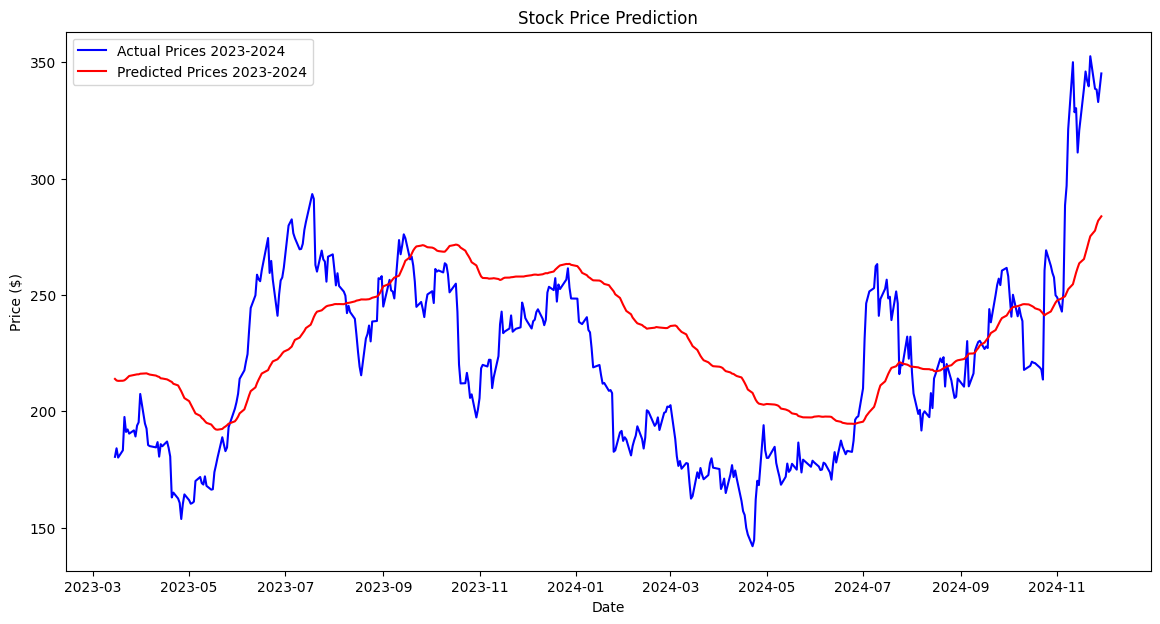

Accuracy: 86.66%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def compute_RSI(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Function to fetch and preprocess stock data
def load_and_preprocess_data(company, start_date, end_date):
    stock_data = yf.download(company, start=start_date, end=end_date, interval='1d')
    stock_data['SMA'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=50).mean()
    stock_data['RSI'] = compute_RSI(stock_data['Close'])

    # Drop rows with NaN values
    stock_data = stock_data.dropna()

    return stock_data

# Function to preprocess data for LSTM
def preprocess_data(data, seq_length):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close', 'SMA', 'EMA', 'RSI']]) 

    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i])
        y.append(scaled_data[i, 0])  

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler

# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=input_shape)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def main():
    company = 'TSLA'
    start_train = '2010-01-01'
    end_train = '2022-12-31'
    start_predict = '2023-01-01'
    end_predict = '2024-12-31'

    # Load and preprocess training data
    train_data = load_and_preprocess_data(company, start_train, end_train)
    seq_length = 60
    X_train, y_train, scaler = preprocess_data(train_data, seq_length)

    # Train the model
    model = build_model((seq_length, X_train.shape[2]))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stop])

    # Load and preprocess prediction data
    prediction_data = load_and_preprocess_data(company, start_predict, end_predict)
    
    # Combine training and prediction data for scaling
    total_data = pd.concat((train_data[['Close', 'SMA', 'EMA', 'RSI']], prediction_data[['Close', 'SMA', 'EMA', 'RSI']]))
    total_data = total_data.dropna()
    
    # Preprocess for prediction
    X_total, _, _ = preprocess_data(total_data, seq_length)
    
    # Make predictions
    predictions = model.predict(X_total[-len(prediction_data):]) 
    predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], total_data.shape[1] - 1))), axis=1))[:, 0]

    # Prepare actual values for comparison
    actual_values = prediction_data['Close'].values

    # Plotting results
    plt.figure(figsize=(14, 7))
    plt.plot(prediction_data.index, actual_values, color='blue', label='Actual Prices 2023-2024')
    plt.plot(prediction_data.index, predictions, color='red', label='Predicted Prices 2023-2024')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()

    # Calculate accuracy
    accuracy = calculate_accuracy(actual_values, predictions)
    print(f"Accuracy: {accuracy:.2f}%")

def calculate_accuracy(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  
    accuracy = 100 - mape  
    return accuracy

main()
